In [1]:
import sys
assert sys.version_info >= (3, 5)

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

import numpy as np
import time

In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

#check os.environ ld_library_path is the same here as when I do it in python via terminal, if I get issues

#sometimes I can't select the GPU. In this case, try: https://forums.fast.ai/t/tip-limiting-tensorflow-to-one-gpu/1995

In [3]:
K = keras.backend


mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test,y_test) = mnist.load_data()

X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0

y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

X_test = X_test / 255.0

#1000 labelled points in train set for this example

X_train_la = X_train[:1000]
X_train_un = X_train[1000:]

y_train_la = y_train[:1000]
y_train_un = np.empty((X_train_la.shape[0]))


y_train_la = y_train_la.reshape(-1,1)

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train_la = encoder.fit_transform(y_train_la)

y_train_la=y_train_la.toarray()

y_valid = y_valid.reshape(-1,1)
y_valid = encoder.transform(y_valid)
y_valid = y_valid.toarray()

In [7]:
#yes this cell is very similar to the above. It's just so I could get a non-one hot encoded y for the SVM task. Probably
#should clean this up!

(X_train_full, y_train_full), (X_test,y_test2) = mnist.load_data()

y_valid2, y_train2 = y_train_full[:5000], y_train_full[5000:]


#1000 labelled points in train set for this example


y_train_la2 = y_train2[:1000]


y_train_la2 = y_train_la2.reshape(-1,1)

# M1 # 

In [4]:
#encoder

tf.random.set_seed(42)
np.random.seed(42)

class Sampling_M1(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var/2) + mean

codings_size_M1 = 50

inputs_M1 = keras.layers.Input(shape=[28, 28])
z_M1 = keras.layers.Flatten()(inputs_M1)
z_M1 = keras.layers.Dense(600, activation="softplus")(z_M1)
z_M1 = keras.layers.Dense(300, activation="softplus")(z_M1)
codings_mean_M1 = keras.layers.Dense(codings_size_M1)(z_M1)
codings_log_var_M1 = keras.layers.Dense(codings_size_M1)(z_M1)
codings_M1 = Sampling_M1()([codings_mean_M1, codings_log_var_M1])
variational_encoder_M1 = keras.models.Model(
    inputs=[inputs_M1], outputs=[codings_mean_M1, codings_log_var_M1, codings_M1])


#decoder
decoder_inputs_M1 = keras.layers.Input(shape=[codings_size_M1])
x_M1 = keras.layers.Dense(300, activation="softplus")(decoder_inputs_M1)
x_M1 = keras.layers.Dense(600, activation="softplus")(x_M1)
x_M1= keras.layers.Dense(28 * 28, activation="sigmoid")(x_M1)
outputs_M1 = keras.layers.Reshape([28, 28])(x_M1)
variational_decoder_M1 = keras.models.Model(inputs=[decoder_inputs_M1], outputs=[outputs_M1])

#vae
_, _, codings_M1 = variational_encoder_M1(inputs_M1)
reconstructions_M1 = variational_decoder_M1(codings_M1)
variational_ae_M1 = keras.models.Model(inputs=[inputs_M1], outputs=[reconstructions_M1])

beta = 1
latent_loss_M1 = beta*-0.5 * K.sum(
    1 + codings_log_var_M1 - K.exp(codings_log_var_M1) - K.square(codings_mean_M1),
    axis=-1)
variational_ae_M1.add_loss(K.mean(latent_loss_M1) / 784)
#question on how loss is computed too..
variational_ae_M1.compile(loss="binary_crossentropy", optimizer="rmsprop")


early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)



In [5]:
history = variational_ae_M1.fit(X_train, X_train, epochs=100, batch_size=64,
                             validation_data=(X_valid, X_valid),  callbacks=[early_stopping_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 4s 76us/sample - loss: 0.2265 - val_loss: 0.1895
Epoch 2/100
55000/55000 [==============================] - 3s 55us/sample - loss: 0.1784 - val_loss: 0.1702
Epoch 3/100
55000/55000 [==============================] - 3s 57us/sample - loss: 0.1621 - val_loss: 0.1585
Epoch 4/100
55000/55000 [==============================] - 3s 58us/sample - loss: 0.1542 - val_loss: 0.1529
Epoch 5/100
55000/55000 [==============================] - 3s 57us/sample - loss: 0.1491 - val_loss: 0.1463
Epoch 6/100
55000/55000 [==============================] - 3s 58us/sample - loss: 0.1457 - val_loss: 0.1454
Epoch 7/100
55000/55000 [==============================] - 3s 59us/sample - loss: 0.1430 - val_loss: 0.1442
Epoch 8/100
55000/55000 [==============================] - 3s 60us/sample - loss: 0.1409 - val_loss: 0.1417
Epoch 9/100
55000/55000 [==============================] - 3s 56us/sample - loss: 0.139

### Attempt to save the model ###

In [61]:
config = variational_ae_M1.get_config()

In [62]:
custom_objects = {"Sampling_M1":Sampling_M1}

In [63]:
variational_ae_M1.save("M1_model.h5",save_format="tf")

In [67]:
model_Vae = keras.models.load_model("M1_model.h5",custom_objects=custom_objects)

In [47]:
variational_ae.save("M1_model.h5",save_format="tf") #doesn't work properly as need to deal with the sampling layer.
#refer to geron textbook for how to do this

In [6]:
#Generate the latent representations


X_train_la_encoded,_,_ = variational_encoder_M1(X_train_la)
X_train_la_encoded = X_train_la_encoded.numpy()

X_train_un_encoded,_,_ = variational_encoder_M1(X_train_un)
X_train_un_encoded = X_train_un_encoded.numpy()

X_valid_encoded,_,_ = variational_encoder_M1(X_valid)
X_valid_encoded = X_valid_encoded.numpy()

X_test_encoded,_,_ = variational_encoder_M1(X_test)
X_test_encoded = X_test_encoded.numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [11]:
np.save("X_train_la_encoded.npy",X_train_la_encoded)
np.save("X_train_un_encoded.npy",X_train_un_encoded)
np.save("X_valid_encoded.npy",X_valid_encoded)
np.save("X_test_encoded.npy",X_test_encoded)

In [390]:
X_train_un_encoded = np.load("X_train_un_encoded.npy")
X_train_la_encoded = np.load("X_train_la_encoded.npy")
X_valid_encoded = np.load("X_valid_encoded.npy")
X_test_encoded = np.load("X_test_encoded.npy")

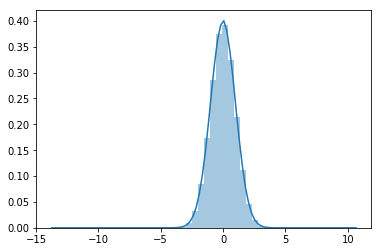

In [51]:
import seaborn
import matplotlib.pyplot as plt

seaborn.distplot(X_test_encoded)
plt.show()

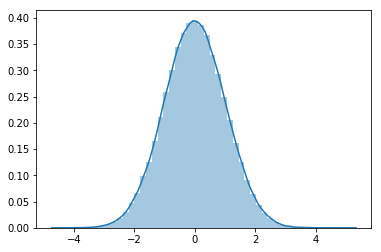

In [215]:
seaborn.distplot(X_valid_encoded)
plt.show()

In [12]:
from sklearn.svm import SVC

svc_class = SVC(kernel="rbf", gamma='scale', random_state=42)
svc_class.fit(X_train_la_encoded_scaled, y_train_la2)
svc_class.score(X_train_la_encoded_scaled, y_train_la2)


/home/rp542/venv/lib/python3.5/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.979

In [13]:
svc_class.score(X_test_encoded_scaled, y_test2)


0.925

In [14]:
svc_class.score(X_valid_encoded_scaled, y_valid2)


0.9312

I've got a useful latent rep in terms of doing classification. Great. Hopefully this results in good scores downstream in M2.

### Processing ###

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_un_encoded_scaled = scaler.fit_transform(X_train_un_encoded)

In [9]:
X_train_la_encoded_scaled = scaler.transform(X_train_la_encoded)
X_valid_encoded_scaled = scaler.transform(X_valid_encoded)
X_test_encoded_scaled = scaler.transform(X_test_encoded)

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler2= MinMaxScaler()

X_train_un_encoded_scaled = scaler2.fit_transform(X_train_un_encoded)

In [11]:
X_train_la_encoded_scaled = scaler2.transform(X_train_la_encoded)
X_valid_encoded_scaled = scaler2.transform(X_valid_encoded)
X_test_encoded_scaled = scaler2.transform(X_test_encoded)

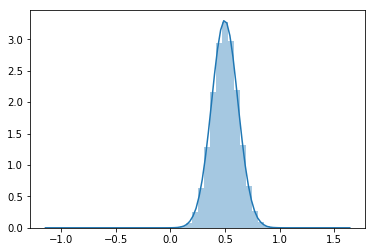

In [111]:
seaborn.distplot(X_test_encoded_scaled)
plt.show()

# M2 # 

## Encoder ##

In [15]:
#need to set input and output shapes depending on x and y shapes
x_input_shape = 50

tf.random.set_seed(42)
np.random.seed(42)

#reparameterization trick
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var/2) + mean

codings_size = 50

x_in = keras.layers.Input(shape=[50])
f = keras.layers.Flatten()(x_in)
z = keras.layers.Dense(300, activation="softplus")(f)
z = keras.layers.Dense(300, activation="softplus")(z)

#z = keras.layers.Dropout(0.2)(z)

codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])

 

variational_encoder = keras.models.Model(
    inputs=[x_in], outputs=[codings_mean, codings_log_var, codings])

## Classifier ##

In [16]:
y_classifier = keras.layers.Dense(300, activation="elu")(f)

#y_classifier = keras.layers.Dropout(0.2)(y_classifier)
y_pred = keras.layers.Dense(10,activation="softmax")(y_classifier) 

classifier = keras.models.Model(
    inputs=[x_in], outputs=[y_pred])


## Decoder ##

In [17]:
def x_activation(value):
    return 6*tf.keras.activations.tanh(value)

latent = keras.layers.Input(shape=[codings_size])
y = keras.layers.Input(shape=[10])

l_merged = keras.layers.concatenate([latent,y])
x = keras.layers.Dense(300, activation="softplus")(l_merged)
x = keras.layers.Dense(300, activation="softplus")(x)

#x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(50,activation="sigmoid")(x)
x_out = keras.layers.Reshape([50])(x)


variational_decoder = keras.models.Model(inputs=[latent,y], outputs=[x_out])

## Compile model ##

In [18]:
#labelled vae
_,_, codings = variational_encoder(x_in)
y_pred = classifier(x_in)
reconstructions = variational_decoder([codings,y])
label_vae = keras.models.Model(inputs=(x_in,y), outputs=(reconstructions,y_pred))

In [19]:
#unlabelled vae
_,_, codings = variational_encoder(x_in)
y_pred = classifier(x_in)
reconstructions_un = variational_decoder([codings,y_pred])
unlabel_vae = keras.models.Model(inputs=x_in, outputs=reconstructions_un)

In [20]:
def labelled_loss_reconstruction(codings_log_var,codings_mean):
    def loss_functions_labelled(x, x_decoded_mean):
        x = K.reshape(x,[-1,50])
        x_decoded_mean = K.reshape(x_decoded_mean,[-1,50])
        xent_loss = 50*keras.losses.binary_crossentropy(x, x_decoded_mean)        
        kl_loss = - 0.5 * K.sum(1 + codings_log_var - K.square(codings_mean) - K.exp(codings_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    return loss_functions_labelled 

def unlabelled_loss_reconstruction(codings_log_var,codings_mean,y_pred):
    def loss_functions_unlabelled(x,x_decoded_mean):
        x = K.reshape(x,[-1,50])
        x_decoded_mean = K.reshape(x_decoded_mean,[-1,50])
        kl_loss = - 0.5 * K.sum(1 + codings_log_var - K.square(codings_mean) - K.exp(codings_log_var), axis=-1)
        xent_loss = 50*keras.losses.binary_crossentropy(x, x_decoded_mean)        
        entropy = keras.losses.categorical_crossentropy(y_pred,y_pred)
        loss = K.mean(kl_loss + xent_loss)
        #need to check below. We are summing over y, but we are assuming that the loss term is independent of y
        #which is not the case. How to do it though? https://github.com/bjlkeng/sandbox/issues/3
        #and how to do it for regression?
        return K.mean(K.sum(y_pred*loss,axis=-1)) + K.mean(entropy)
    return loss_functions_unlabelled

def labelled_cls_loss(y, y_pred,N=1000):
    alpha = 0.1*N
    cat_xent_loss = keras.losses.categorical_crossentropy(y, y_pred)
    return alpha*K.mean(cat_xent_loss)

In [21]:
optimizer_adam = keras.optimizers.Adam(learning_rate=0.0001)

In [22]:
label_vae.compile(loss=[labelled_loss_reconstruction(codings_log_var,codings_mean)
                        ,labelled_cls_loss], optimizer=optimizer_adam, experimental_run_tf_function=False)

unlabel_vae.compile(loss=unlabelled_loss_reconstruction(codings_log_var,codings_mean,y_pred),
                    optimizer=optimizer_adam, experimental_run_tf_function=False)

In [18]:
label_vae.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
model_5 (Model)                 [(None, 50), (None,  241000      input_5[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
model_7 (Model)                 (None, 50)           228950      model_5[1][2]                    
                                                                 input_7[0][0]              

In [ ]:
#for debugging

history = label_vae.fit(
    [X_train_la_encoded_scaled,y_train_la], [X_train_la_encoded_scaled,y_train_la], epochs=1, #batch_size=128,
    validation_data=([X_valid_encoded_scaled,y_valid], [X_valid_encoded_scaled,y_valid])
)


In [ ]:

#for debugging

history = unlabel_vae.fit(
    [X_train_un_encoded], [X_train_un_encoded], epochs=1, #batch_size=128,
    validation_data=([X_valid_encoded], [X_valid_encoded])
)

## Create batches ##

In [28]:
#omer method - just picks things at random so each epoch may not necessarily go through every single point.
#but easier implementation for now

def create_batch(x_label, y_label, x_unlabel, batch_s=64):
    '''
    Creates batches of labelled and unlabelled data. The total number of points in both batches is equal to batch_s. 
    
    '''
    proportion_labelled = x_label.shape[0]/(x_label.shape[0] + x_unlabel.shape[0])
    
    shape_label = x_label.shape[0]
    label_per_batch = int(np.ceil(proportion_labelled*batch_s))
    batch_idx_la = np.random.choice(list(range(shape_label)), label_per_batch)
    batch_x_la = (x_label[batch_idx_la, :])
    batch_y_la = (y_label[batch_idx_la])
    
    shape_unlabel = x_unlabel.shape[0]
    unlabel_per_batch = batch_s - label_per_batch
    batch_idx_un = np.random.choice(list(range(shape_unlabel)), unlabel_per_batch)
    batch_x_un = (x_unlabel[batch_idx_un, :])
    
    del batch_idx_la,batch_idx_un
            
    return batch_x_la, batch_y_la, batch_x_un

## Train ##

In [23]:
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["Loss: {:.4f}".format(loss)])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)
    
def print_status_bar_epoch(iteration, total, loss, validation_loss, metrics=None, size=30):
    metrics = " - ".join(["Loss: {:.4f} Validation loss: {:.4f} ".format(loss,validation_loss)])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)
    
#could make these functions into just one which works for both if I want. See the Geron textbook.

In [24]:
def list_average(list_of_losses):
    return sum(list_of_losses)/len(list_of_losses)

In [25]:

#for below
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["Loss for batch: {:.4f}".format(loss)])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)
    
def print_status_bar_epoch(iteration, total, training_loss_for_epoch,train_recon, train_reg,
                                   train_unlabel,val_loss,val_recon_loss,val_reg_loss, metrics=None, size=30):
    metrics = " - ".join(
        ["trainLoss: {:.4f} tRecon: {:.4f} ty_pred: {:.4f} tUnlabel: {:.4f} Val_loss: {:.4f} Val_recon: {:.4f} Val_reg: {:.4f}".format(
            training_loss_for_epoch,train_recon, train_reg,
                                   train_unlabel,val_loss,val_recon_loss,val_reg_loss)]
    )
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)
    
#could make these functions into just one which works for both if I want. See the Geron textbook.

In [29]:
def fit_model(X_train_la, y_train_la, X_train_un,epochs,X_valid_la, y_valid_la,patience,batch_size=64):

    """
    Fits the model. Gets the validation loss too. And includes early stopping, given by the patience.
    
    """
    #The callback still doesn't take the model back to the model which performed best.. how to implement that?
    #maybe save the model after each epoch in a list of max size 10.
    #if we callback is reached, look at val loss list and see index which is smallest and choose that for model restoration
    
    start = time.time()
    history = []
    
    validation_loss = []
    
    batch_loss = []
    batch_recon = []
    batch_reg = []
    batch_unlabel = []
    
    batches_per_epoch = int(np.floor((X_train_la.shape[0] + X_train_un.shape[0])/batch_size))

    for epoch in range(epochs):
            
            print("Epoch {}/{}".format(epoch,epochs))
            
            for i in range(batches_per_epoch):

                batch_x_la, batch_y_la, batch_x_un = create_batch(X_train_la,y_train_la,X_train_un,batch_size)

                unlabel_loss = unlabel_vae.train_on_batch([batch_x_un],
                                                 [batch_x_un])

                label_loss_recon = label_vae.train_on_batch([batch_x_la,batch_y_la],
                                                [batch_x_la,batch_y_la])[1] 
                
                label_loss_y = label_vae.train_on_batch([batch_x_la,batch_y_la],
                                                [batch_x_la,batch_y_la])[2] 
                
                loss= unlabel_loss+label_loss_recon+label_loss_y
                
                batch_recon.append(label_loss_recon)
                batch_reg.append(label_loss_y)
                batch_unlabel.append(unlabel_loss)
                
                batch_loss.append(loss)
                average_batch_loss = list_average(batch_loss)
                print_status_bar(i*batch_size,X_train_la.shape[0] + X_train_un.shape[0],average_batch_loss)
                
            training_loss_for_epoch = list_average(batch_loss)
            train_recon = list_average(batch_recon)
            train_reg = list_average(batch_reg)
            train_unlabel = list_average(batch_unlabel)

            batch_loss = []
            batch_recon = []
            batch_reg = []
            batch_unlabel = []
                
            history.append(training_loss_for_epoch)
            
            val_loss = label_vae.evaluate([X_valid_la,y_valid_la],[X_valid_la,y_valid_la],verbose=0)[0];
            
            val_recon_loss = label_vae.evaluate([X_valid_la,y_valid_la],[X_valid_la,y_valid_la],verbose=0)[1];

            val_reg_loss = label_vae.evaluate([X_valid_la,y_valid_la],[X_valid_la,y_valid_la],verbose=0)[2];
            
            validation_loss.append(val_loss)
                
            print_status_bar_epoch(X_train_la.shape[0] + X_train_un.shape[0]
                             ,(X_train_la.shape[0] + X_train_un.shape[0]),training_loss_for_epoch,train_recon, train_reg,
                                   train_unlabel,val_loss,val_recon_loss,val_reg_loss)
            
            #callback for early stopping
            if epoch > patience - 1:
                
                latest_val_loss = validation_loss[-patience:]
                if all(i<=val_loss for i in latest_val_loss) is True:
                    break
            
            
                
    done = time.time()
    elapsed = done-start
    print("Elapsed/s: ",elapsed)
    print("Final training loss: ",training_loss_for_epoch)
    
    return history

In [70]:
history = fit_model(X_train_la_encoded_scaled, y_train_la, X_train_un_encoded_scaled,200,X_valid_encoded_scaled,y_valid,patience=10,batch_size=64)

Epoch 0/200
55000/55000 [==============================] - trainLoss: 84.6722 tRecon: 34.1434 ty_pred: 16.1208 tUnlabel: 34.4080 Val_loss: 63.9988 Val_recon: 34.1533 Val_reg: 29.7790
Epoch 1/200
55000/55000 [==============================] - trainLoss: 83.1775 tRecon: 34.1174 ty_pred: 14.6561 tUnlabel: 34.4040 Val_loss: 64.9535 Val_recon: 34.1512 Val_reg: 30.7648
Epoch 2/200
55000/55000 [==============================] - trainLoss: 81.1029 tRecon: 34.1351 ty_pred: 12.5624 tUnlabel: 34.4054 Val_loss: 69.5679 Val_recon: 34.1549 Val_reg: 35.3887
Epoch 3/200
55000/55000 [==============================] - trainLoss: 82.4765 tRecon: 34.1218 ty_pred: 13.9584 tUnlabel: 34.3963 Val_loss: 65.5479 Val_recon: 34.1547 Val_reg: 31.2727
Epoch 4/200
55000/55000 [==============================] - trainLoss: 83.5292 tRecon: 34.1342 ty_pred: 15.0008 tUnlabel: 34.3943 Val_loss: 71.9349 Val_recon: 34.1515 Val_reg: 37.6621
Epoch 5/200
55000/55000 [==============================] - trainLoss: 83.2490 tRecon:

# Test #

In [19]:
X_test_encoded.shape

(10000, 300)

In [20]:
y_test = y_test.reshape(-1,1)
y_test = encoder.transform(y_test)
y_test = y_test.toarray()

In [71]:
y_prediction = classifier.predict(X_valid_encoded_scaled)

In [72]:
from sklearn.metrics import log_loss

xent_loss = log_loss(y_valid,y_prediction)

In [73]:
xent_loss

0.38124066108700844

In [74]:
y_pred_rounded = np.round(y_prediction,0)

In [75]:
from sklearn.metrics import accuracy_score as accuracy

accuracy_score = accuracy(y_valid,y_pred_rounded)

accuracy_score

0.8718

In [76]:
y_pred_rounded_train = np.round(classifier.predict(X_train_la_encoded_scaled),0)

In [77]:
xent_loss = log_loss(y_train_la,y_pred_rounded_train)

In [78]:
xent_loss

2.2841644129753114

In [79]:
accuracy(y_train_la,y_pred_rounded_train)

0.918

Not as good as M1 nor M2 yet. Maybe with regularisation + longer training we'd get there.

Maybe the models need to be trained jointly, as in having a probabilistic model overall, unlike what is done here, where M1 is used as a feature extractor? Can try this out...

In [59]:
classifier.save("m1+m2_poor_classifier.h5") 